Simulation Scenario #2 (Index 2 in the simulation_scenario document except with less variation)

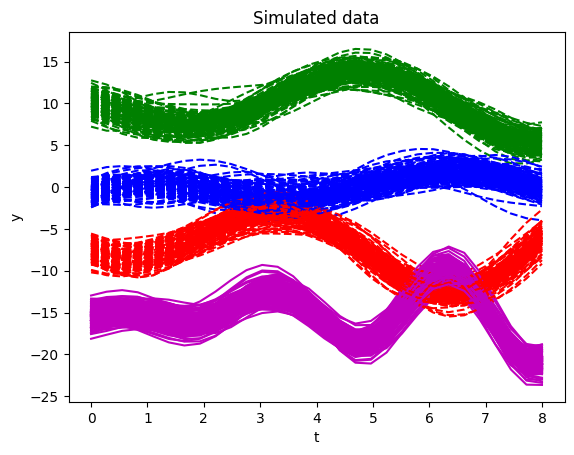

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import spatial, interpolate
from ensemble_clustering import functional_data_decomposition, functional_data_clustering
from fda_results import percentage_variation_ami_ari, plot_percentage_variation_ami_ari

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Define the exponentiated quadratic 
def exponentiated_quadratic(xa, xb):
    """Exponentiated quadratic  with σ=1"""
    # L2 distance (Squared Euclidian)
    sq_norm = -0.5 * scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')
    return np.exp(sq_norm)

# Sample from the Gaussian process distribution
nb_of_samples = 30  # Number of points in each function
# Independent variable samples
t = np.expand_dims(np.linspace(0, 8, nb_of_samples), 1)
Σ = exponentiated_quadratic(t, t)  # Kernel of data points

# Create different curves
mean_curve = np.zeros((4, len(t)))
mean_curve[0] = np.reshape(10-2*np.sin(t)*np.log(t+2), (nb_of_samples))
mean_curve[1] = np.reshape(1*np.cos(t)*np.log(t+0.5), (nb_of_samples))
mean_curve[2] = np.reshape(-5 + -2-np.cos(t)*(np.sqrt(5*t+0.5)), (nb_of_samples))
mean_curve[3] = np.reshape(-15 + np.cos(2*t)*np.log(t+0.5)*(np.sqrt(t+0.5)), (nb_of_samples))

mixture_k = [1/4, 1/4, 1/4, 1/4	]
n = 500
Y = np.zeros((n, len(t)))
simulation_label = np.zeros(n)

for i in range(n):
    # generate a random number between 0 and 1
    r = np.random.rand()
    # find the index of the mixture component
    if r < mixture_k[0]:
        # draw for the first component
        ys = np.random.multivariate_normal(
        mean=mean_curve[0], cov=Σ, 
        size=1)
        Y[i] = ys
        plt.plot(t, ys[0], linestyle='--', color='g')
        # Remember the label of the component
        simulation_label[i] = 0

    elif r < mixture_k[0] + mixture_k[1]:
        # draw for the second component
        # draw for the first component
        ys = np.random.multivariate_normal(
        mean=mean_curve[1], cov=Σ, 
        size=1)
        Y[i] = ys
        plt.plot(t, ys[0], linestyle='--', color='b')
        # Remember the label of the component
        simulation_label[i] = 1

    
    elif r < mixture_k[0] + mixture_k[1] + mixture_k[2]:
        # draw for the first component
        ys = np.random.multivariate_normal(
        mean=mean_curve[2], cov=Σ, 
        size=1)
        Y[i] = ys
        plt.plot(t, ys[0], linestyle='--', color='r')
        # Remember the label of the component
        simulation_label[i] = 2

    else:
        # draw for the first component
        ys = np.random.multivariate_normal(
        mean=mean_curve[3], cov=Σ, 
        size=1)
        Y[i] = ys
        plt.plot(t, ys[0], linestyle='-', color='m')
        # Remember the label of the component
        simulation_label[i] = 3

plt.title('Simulated data')
plt.xlabel('t')
plt.ylabel('y')
plt.show()

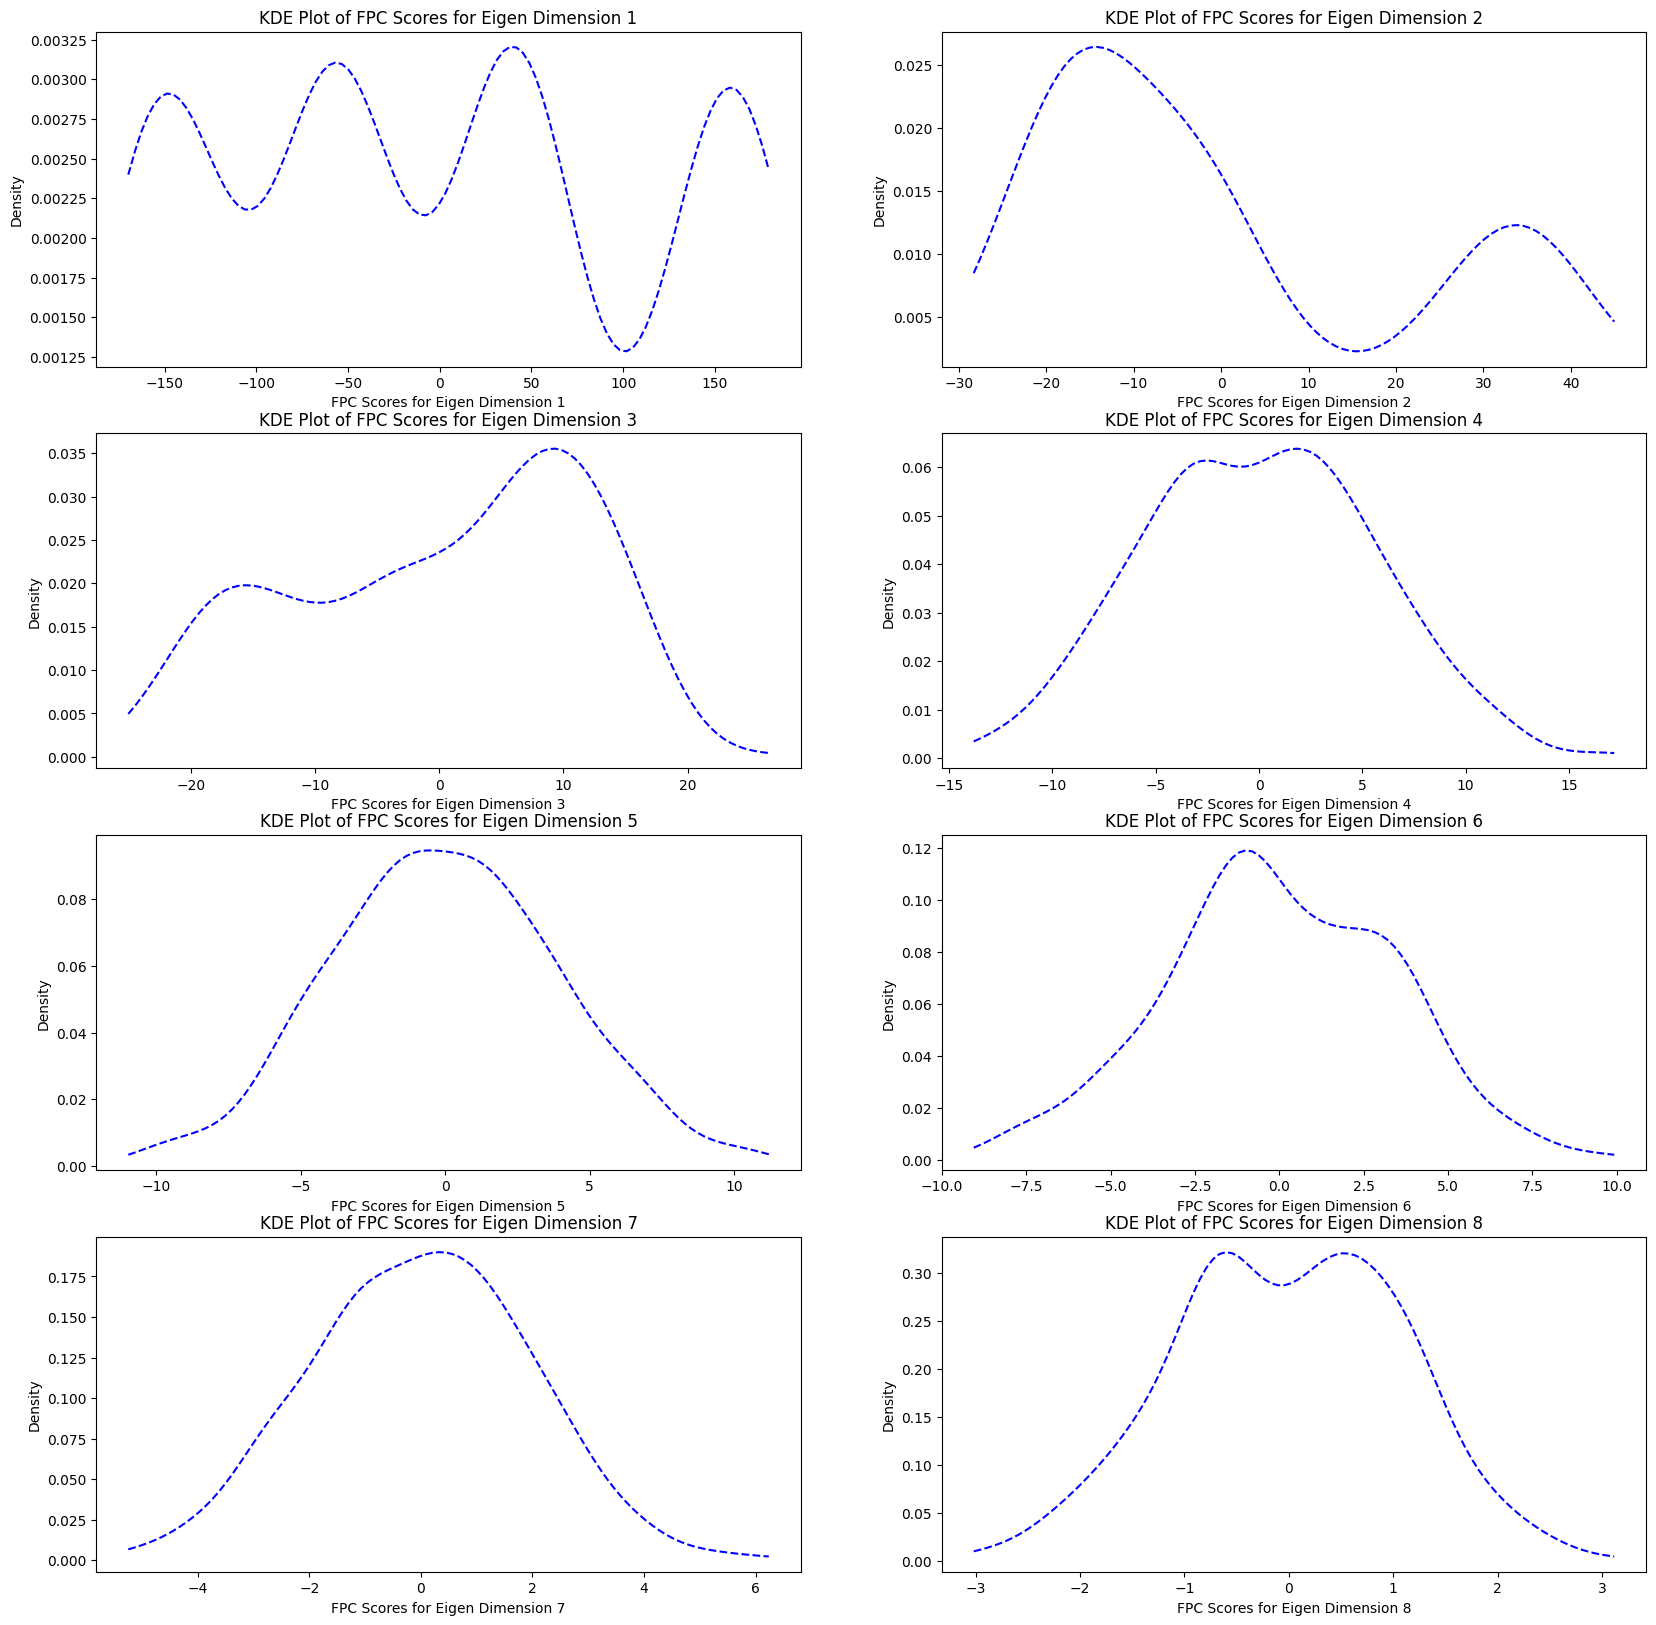

In [5]:
data_smooth, mean, principal_componenets, eigen_functions = functional_data_decomposition (Y, 10, 150)

# For loop to plot a 2x2 set of scatter plots for the kernel density plots of the first four principal components
fig, ax = plt.subplots(4, 2, figsize=(20, 20))
for i in range(8):
    # Kernel density plot for principal components[i], as a scatter plot
    # Determine the desnity of principal components[i]
    kde = scipy.stats.gaussian_kde(principal_componenets[:,i])
    # Create a grid of points
    x_grid = np.linspace(min(principal_componenets[:,i]), max(principal_componenets[:,i]), 100)
    # Evaluate the density on the grid
    density = kde(x_grid)
    # Plot the density
    ax[i//2, i%2].plot(x_grid, density, color='b', linestyle='--')
    ax[i//2, i%2].set_title('KDE Plot of FPC Scores for Eigen Dimension ' + str(i+1))
    ax[i//2, i%2].set_xlabel('FPC Scores for Eigen Dimension ' + str(i+1))
    ax[i//2, i%2].set_ylabel('Density')
plt.show()

Percentage of variation explained by each eigen dimensions:  [9.52361558e-01 3.27971114e-02 1.01340542e-02 2.27594939e-03
 1.16966386e-03 8.38445933e-04 2.79374752e-04 8.69292789e-05
 4.23756832e-05 1.45378148e-05]


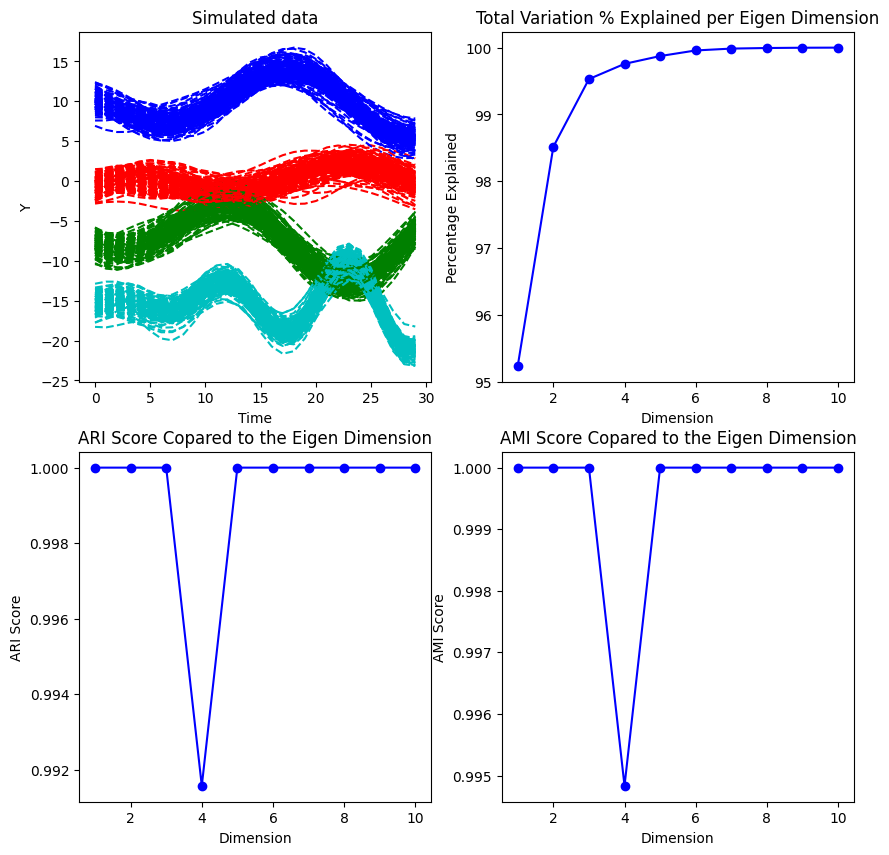

In [6]:
variance, ami, ari, v_range = percentage_variation_ami_ari(10, Y, 150, simulation_label, 4)
plot_percentage_variation_ami_ari(variance, ami, ari, v_range, simulation_label, Y)

In [6]:
# Determine the Eigen Dimension that explains 95% of the variance
for i in range(len(variance)):
    if sum(variance[:i]) >= 0.95:
        print('The Eigen Dimension that explains 95% of the variance is ' + str(i))
        V = i -1
        if V == 0:
            V = 1
        break

The Eigen Dimension that explains 95% of the variance is 4


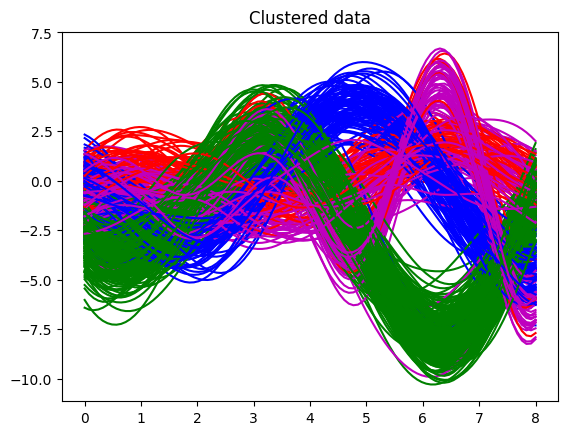

AMI score:
0.8166939211418468
ARI score:
0.8967984732151615


In [7]:
# Get data from the first function
data_smooth, mean, principal_componenets, eigen_functions = functional_data_decomposition (Y, V, 100)

# Get data from the second function
membership_matrices, labels = functional_data_clustering (principal_componenets, 4)

# Plot the curves with their labels
t = np.expand_dims(np.linspace(0, 8, len(data_smooth[0])), 1)
for i in range(len(data_smooth)):
    if labels[i] == 0:
        plt.plot(t, data_smooth[i], '-m')
    elif labels[i] == 1:
        plt.plot(t, data_smooth[i], '-g')
    elif labels[i] == 2:
        plt.plot(t, data_smooth[i], '-b')
    else:
        plt.plot(t, data_smooth[i], '-r')
plt.title('Clustered data')
plt.show()

# Get the AMI score
from sklearn.metrics.cluster import adjusted_mutual_info_score
print("AMI score:")
print(adjusted_mutual_info_score(simulation_label, labels))

# Get the ARM score
from sklearn.metrics.cluster import adjusted_rand_score
print("ARI score:")
print(adjusted_rand_score(simulation_label, labels))

In [11]:
from FDApy.clustering.fcubt import Node, FCUBT
from FDApy.representation.functional_data import DenseFunctionalData

# Make t a dict
t = np.expand_dims(np.linspace(0, 20, len(Y[0])), 1)
t = {'input_dim_0': t}
# Change t from (100, 1) to (100,)
t = {k: v.squeeze() for k, v in t.items()}

data = DenseFunctionalData(t, Y)
# Build the tree
root_node = Node(data, is_root=True)
fcubt = FCUBT(root_node=root_node)

# Growing
fcubt.grow(n_components=0.95, min_size=10)

# Joining
fcubt.join(n_components=0.95)

# Get the ARI
print("ARI score for FCUBT: %f" % adjusted_rand_score(simulation_label, fcubt.labels_join))
# Get the AMI
print("AMI score for FCUBT: %f" % adjusted_mutual_info_score(simulation_label, fcubt.labels_join))

ARI score for FCUBT: 0.996867
AMI score for FCUBT: 0.990595


In [40]:
# Store the data in DataStore.csv
np.savetxt('Data/DataStore.csv', Y, delimiter=',')
np.savetxt('Data/LabelStore.csv', simulation_label, delimiter=',')

In [41]:
# To simulate funHDDC, run run the R file funHDDC.R

from sklearn.metrics.cluster import adjusted_mutual_info_score, adjusted_rand_score
# Read Labels from PredictedLabels.csv, ignoring the header and the first column
predicted_labels = np.genfromtxt('Data/PredictedLabelsStore.csv', delimiter=',', skip_header=1, usecols=1)
print("ARI score for funHDDC: %f" % adjusted_rand_score(simulation_label, predicted_labels))
print("AMI score for funHDDC: %f" % adjusted_mutual_info_score(simulation_label, predicted_labels))

ARI score for funHDDC: 0.270789
AMI score for funHDDC: 0.560795


In [34]:
# To simulate funFEM, run run the R file funFEM.R

# Read labels from PredictedLabels.csv, ignoring the header and the first column and getting the first four columns
predicted_labels = np.genfromtxt('Data/PredictedLabelsStore.csv', delimiter=',', skip_header=1, usecols=range(1, 5))
#   Format the labels
labels = np.zeros(len(predicted_labels))
for i in range(len(predicted_labels)):
    labels[i] = np.argmax(predicted_labels[i])
print("ARI score for funFEM: %f" % adjusted_rand_score(simulation_label, labels))
print("AMI score for funFEM: %f" % adjusted_mutual_info_score(simulation_label, labels))


ARI score for funFEM: 0.271049
AMI score for funFEM: 0.397864
